# LSO Handin 2 - Subset Selection Problem

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyomo.environ as pyomo
from copy import copy
import random

## Data Inspection

In [2]:
def get_data():
    df = pd.read_csv("CO2_economic.csv")
    X = df.drop(['CO2-GR', 'year'], axis=1).to_numpy()
    y = df['CO2-GR'].to_numpy()
    features = set(j for j in range(0, X.shape[1]))
    return df, X, y, features

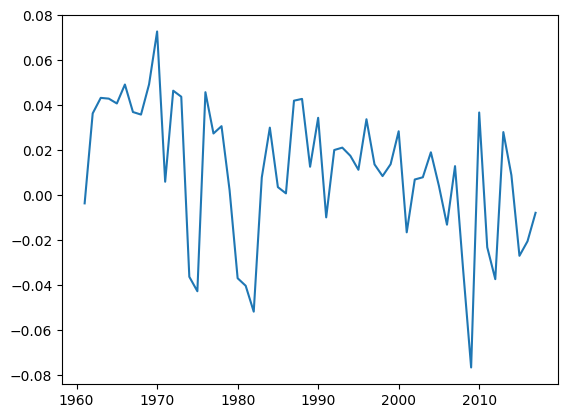

(57, 228)


,year,CO2-GR,FRED-MD-1,FRED-MD-2,FRED-MD-3,FRED-MD-4,FRED-MD-5,FRED-MD-6,FRED-MD-7,FRED-MD-8,...,US_Foreing_73,US_Foreing_74,US_Foreing_75,US_Foreing_76,US_CEMNT-1,US_CEMENT-2,US_TRANS-1,US_TRANS-2,US_TRANS-3,US_TRANS-4
0,1961,-0.003623,0.023464,-0.15530,-0.68443,-0.9180,-1.57080,-0.45069,-0.38606,-0.45797,...,0.716770,-0.60116,0.58925,-0.37866,-0.37213,-0.53299,-0.90675,-0.51371,-0.52343,-0.02997
1,1962,0.036385,0.985230,0.96994,0.93210,0.7986,0.43366,1.27100,1.31310,1.47760,...,-0.057105,0.23945,-0.52090,-0.17336,0.74256,0.65670,0.71695,-0.29572,0.12885,0.21633


In [3]:
df, X, y, features = get_data()

plt.plot(df['year'], df['CO2-GR'])
plt.show()

print(df.shape)
df.head(2)

In [112]:
def compute_beta(X, y, selected_features):

    selected_indicies = list(selected_features)

    X_k = X[:, selected_indicies]

    beta = np.zeros(shape=X.shape[1])
    beta_k, cost, *_ = np.linalg.lstsq(X_k, y, rcond=None)
    beta[selected_indicies] = beta_k

    # cost
    if len(cost) == 0:
        residuals = y - np.matmul(X_k, beta_k)
        cost = [np.dot(residuals, residuals)]

    return beta, cost[0]


def validate_solution(X, y, k, solution):
    # validate cost
    beta = solution['beta']
    residuals = y - X@beta
    cost = np.dot(residuals, residuals)
    assert np.allclose(cost, solution['cost']), 'Error in cost'

    # validate k
    assert beta[beta != 0].shape[0] <= k, f'Error in beta, {beta[beta != 0]} > {k}'

    # validate selected features
    assert len(solution['selected_features']) <= k, f"Error in selected features, {len(solution['selected_features'])} > {k}"


def plot_regression(df, X, y, solution):
    y_hat = X@solution['beta']
    residuals = y - y_hat

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    ax[0].plot(df['year'], y, label='gt', color='blue')
    ax[0].plot(df['year'], y_hat, label='fit', color='red')
    ax[0].legend()
    ax[0].set_ylabel('CO2')
    ax[0].set_xlabel('Year')
    ax[0].set_title('Regression fit')

    ax[1].hlines(0, xmin=df['year'].min(), xmax=df['year'].max(), linestyle='dashed', color='black')
    ax[1].plot(df['year'], residuals, label='fit', color='black')
    ax[1].legend()
    ax[1].set_ylabel('Residual')
    ax[1].set_xlabel('Year')
    ax[1].set_title('Residuals')

    plt.show()

## Greedy LP solution

### LP-relaxation

In [65]:
def CP_model(X, y, k, LB, UB, solver, type):
    n = X.shape[0]
    p = X.shape[1]

    beta_list = list(range(1, p+1))

    if type == 'relaxation':
        z_type = pyomo.NonNegativeReals
    elif type == 'exact':
        z_type = pyomo.Binary
    else:
        raise ValueError

    lower_bound = [LB for j in beta_list]
    upper_bound = [UB for j in beta_list]

    model = pyomo.ConcreteModel()
    model.beta = pyomo.Var(beta_list, within=pyomo.Reals)
    model.z = pyomo.Var(beta_list, within=z_type, bounds=[0, 1])

    model.obj = pyomo.Objective(
        expr=sum([(y[i-1] - sum([X[i-1, j-1]*model.beta[j] for j in beta_list]))**2 for i in range(1, n+1)]),
        sense=pyomo.minimize
    )

    model.csts = pyomo.ConstraintList()
    model.csts.add(
        expr=sum([model.z[j] for j in beta_list]) <= k
    )
    for j in beta_list:
        model.csts.add(
            expr=lower_bound[j-1]*model.z[j] <= model.beta[j]
        )
        model.csts.add(
            expr=model.beta[j] <= upper_bound[j-1]*model.z[j]
        )

    solver.solve(model, tee=False)

    cost = pyomo.value(model.obj)
    beta = np.array([pyomo.value(model.beta[j]) for j in beta_list])
    z = np.array([pyomo.value(model.z[j]) for j in beta_list])

    return cost, beta, z

In [66]:
k = 10

try:
    solver = pyomo.SolverFactory('cplex', executable='/Applications/CPLEX_Studio2211/cplex/bin/arm64_osx/cplex')
    cost_CP, beta_CP, z_CP = CP_model(X=X, y=y, k=k, LB=-100, UB=100, solver=solver, type='relaxation')
except RuntimeError:
    solver = pyomo.SolverFactory('cplex')
    cost_CP, beta_CP, z_CP = CP_model(X=X, y=y, k=k, LB=-100, UB=100, solver=solver, type='relaxation')

print(cost_CP)

0.003287069183264541


### Greedy construction

In [72]:
def greedy_CP_solution(X, y, k, solver):
    # LP-relaxation
    cost_CP, beta_CP, z_CP = CP_model(X=X, y=y, k=k, LB=-100, UB=100, solver=solver, type='relaxation')

    # greedy choose features
    selected_features = set()
    order = np.argsort(z_CP)[::-1]

    for j in range(0, k):
        selected_features.add(int(order[j]))

    # evaluate
    beta, cost = compute_beta(X=X, y=y, selected_features=selected_features)

    output = {'beta':beta, 
              'cost':cost, 
              'selected_features':selected_features
    }
    return output

In [73]:
solution_greedy = greedy_CP_solution(X, y, k, solver)
validate_solution(X, y, k, solution_greedy)
print(solution_greedy['cost'])
print(solution_greedy['selected_features'])

0.027501652907703324
{99, 164, 100, 38, 49, 54, 183, 185, 126, 31}


## Iterated Local Search

### Local Search

In [ ]:
def local_search(X, y, features, k, iteration_max, init):

    beta_initial = init['beta']
    cost_initial = init['cost']
    selected_features = init['selected_features']
    unselected_features = features.difference(selected_features)

    cost_best = copy(cost_initial)
    beta_best = copy(beta_initial)

    for iteration in range(1, iteration_max+1):

        # search for a swap
        best_add = None
        best_remove = None
        for selected in selected_features:
            for unselected in unselected_features:
                # swap a selected and an unselected feature
                selected_new = copy(selected_features)
                selected_new.remove(selected)
                selected_new.add(unselected)
                
                beta_new, cost_new = compute_beta(X, y, selected_new)
                
                # save best solution
                if cost_new < cost_best:
                    cost_best = cost_new
                    best_add = unselected
                    best_remove = selected
                    beta_best = beta_new

        # perform best accept, if no improvement then converge
        if best_add is not None and best_remove is not None:
            selected_features.remove(best_remove)
            selected_features.add(best_add)
        else:
            break
    
    output = {'beta':beta_best, 
              'cost':cost_best,
              'selected_features':selected_features,
              'iterations_LS':iteration
    }
    return output

In [75]:
k = 10
solution_greedy = greedy_CP_solution(X, y, k, solver)
validate_solution(X, y, k, solution_greedy)
print(solution_greedy['cost'])

solution_LS = local_search(X=X, y=y, features=features, k=k, iteration_max=100, init=solution_greedy)
validate_solution(X, y, k, solution_LS)
print(solution_LS['cost'])
print(solution_LS['iterations_LS'])

0.027501652907703324
0.011005123407696833
12


### Iterated Local Search

In [76]:
def perturbation(features, selected_features, degree):
    assert degree <= len(selected_features), f'Pertubation degree {degree} is larger than size of selection features {len(selected_features)}'

    # get unselected features
    unselected_features = features.difference(selected_features)

    # get features to remomve and add
    features_to_remove = set(random.sample(list(selected_features), k=degree))
    features_to_add = set(random.sample(list(unselected_features), k=degree))

    # perturbation
    perturbed_features = copy(selected_features)
    perturbed_features = perturbed_features.difference(features_to_remove)
    perturbed_features = perturbed_features.union(features_to_add)

    return perturbed_features

In [131]:
def ILS(X, y, k, features, init, iteration_ILS, iteration_LS, alpha):
    assert 0 < alpha and alpha < 1, 'alpha must be in range 0 < alpha < 1'

    # initialize best solution
    solution_best = copy(init)

    # initialize current solution that will move around 
    solution_current = copy(init)

    for iteration in range(0, iteration_ILS):
        degree = max(2, int(alpha*k))
        selected_features_perturbed = perturbation(features=features, 
                                                   selected_features=solution_current['selected_features'], 
                                                   degree=degree)

        beta_perturbed, cost_perturbed = compute_beta(X=X, 
                                                      y=y, 
                                                      selected_features=selected_features_perturbed)
        solution_perturbed = {'beta':beta_perturbed, 
                              'cost':cost_perturbed, 
                              'selected_features':selected_features_perturbed
        }

        solution_LS = local_search(X=X, 
                                   y=y, 
                                   features=features, 
                                   k=k, 
                                   iteration_max=iteration_LS, 
                                   init=solution_perturbed)

        # update best solution
        if solution_LS['cost'] < solution_best['cost']:
            solution_best = solution_LS
        
        # acceptance of new solution
        if solution_LS['cost'] < solution_current['cost']:
            solution_current = solution_LS

    return solution_best

In [132]:
k = 10
solution_greedy = greedy_CP_solution(X, y, k=k, solver=solver)
validate_solution(X, y, k, solution_greedy)
print(solution_greedy['cost'])

solution_ILS = ILS(X=X, y=y, k=k, features=features, init=solution_greedy, iteration_ILS=100, iteration_LS=100, alpha=0.5)
validate_solution(X, y, k, solution_ILS)
print(solution_ILS['cost'])

0.027501652907703324
0.009987531303090245


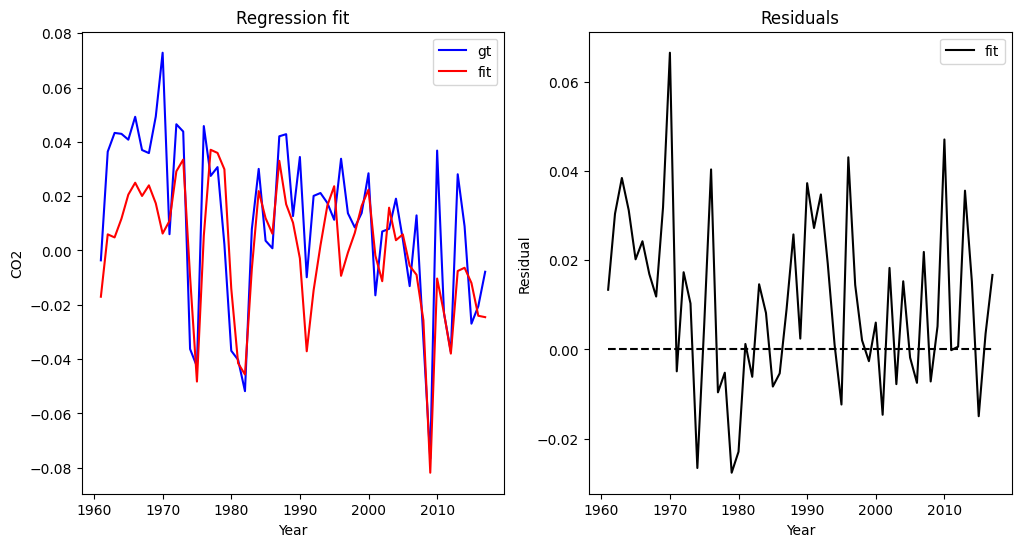

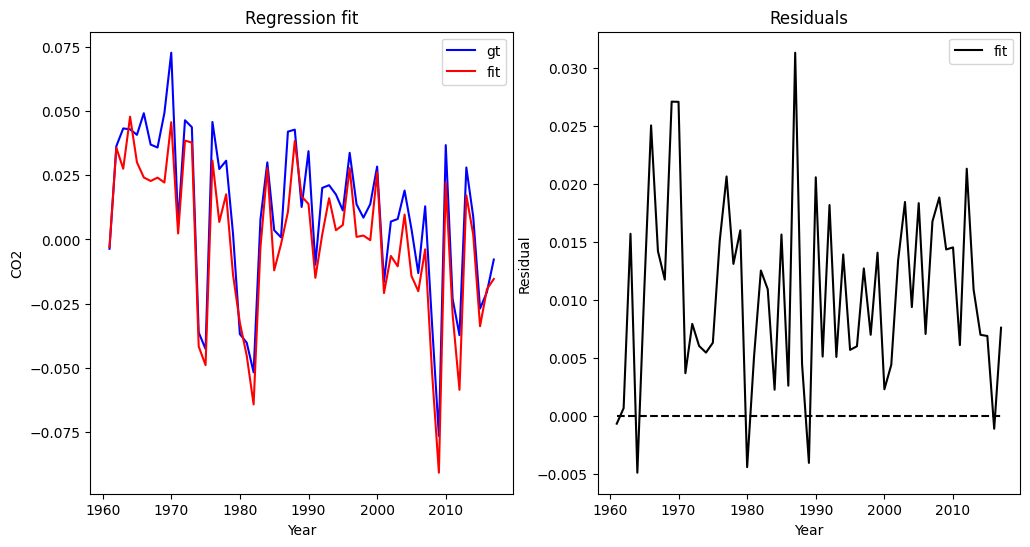

In [133]:
plot_regression(df, X, y, solution_greedy)
plot_regression(df, X, y, solution_ILS)